<a href="https://colab.research.google.com/github/miladbahrami-fs/Independent_Causal_Mechanisms/blob/main/CNN_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch
import time
import os
import matplotlib.pyplot as plt

In [3]:
# Constants
outdir = '.' #path to the output directory
optimizer_experts = 'adam' # optimization algorithm (options: sgd | adam)
optimizer_discriminator ='adam' # optimization algorithm (options: sgd | adam)
optimizer_initialize ='adam' # optimization algorithm (options: sgd | adam)
batch_size = 128 # input batch size for training
input_size = 784 # input size of data
epochs = 100 # number of epochs to train
epochs_init = 100 # number of epochs to initially train experts
no_cuda = False # enables CUDA training
seed = 11 # random seed
log_interval = 10 # how many batches to wait before logging training status
learning_rate_initialize = 1e-1 # size of expert learning rate
learning_rate_expert = 1e-3 #size of expert learning rate
learning_rate_discriminator =1e-3 # size of discriminator learning rate
name = '' #name of experiment
weight_decay = 0 # weight decay for optimizer
num_experts = 5 # number of experts
load_initialized_experts = False # whether to load already pre-trained experts
model_for_initialized_experts ='' # path to pre-trained experts
cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
# Load dataset Original
transform_org = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_org
)

dataset_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_org
)

# Create Dataloader from orginal dataset
data_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=int(cuda), pin_memory=cuda)

100%|██████████| 9912422/9912422 [00:00<00:00, 99967566.69it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32251249.69it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27895657.46it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3473838.21it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.elu3 = nn.ELU()

        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.elu4 = nn.ELU()

        self.conv5 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.elu4(x)

        x = self.conv5(x)
        x = self.sigmoid(x)

        return x


In [12]:
import torch.optim as optim
model = Model()
criterion = nn.MSELoss()
lr = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr)

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(data_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [14]:
PATH = './identical.pth'
torch.save(model.state_dict(), PATH)

In [16]:
dataiter = iter(data_train)
images_org, labels = next(dataiter)
img_out = model(images_org)

# print images
# imshow(torchvision.utils.make_grid(images))
figure = plt.figure(figsize=(8, 8))
plt.imshow(img_out[0].squeeze(), cmap="gray")

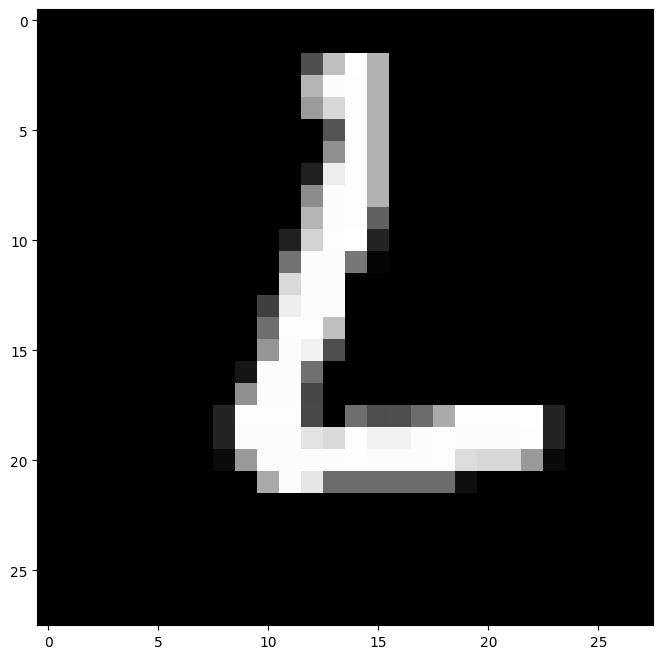

In [22]:
with torch.no_grad():
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(images_org[0].squeeze(), cmap="gray")